In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../..')))

from reservoirgrid.helpers import chaos_utils

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns


In [2]:
path = "../../Examples/Input_Discretization/results/Chaotic/"
save_path = "../../Examples/Input_Discretization/Plots/SingleMetric/"
system_name = "Lorenz"
system_path = os.path.join(path, system_name)

In [3]:
ppp = "/50.0" + ".pkl"
selected_system = path + system_name + ppp
with open(selected_system, "rb") as f:
    data = pickle.load(f)

leaky_rates = []
lyap_times = []
for i in range(len(data)):
    if data[i]["parameters"]["InputScaling"] == 1.0 and data[i]["parameters"]["SpectralRadius"] == 1.0:
        
        leaky = data[i]['parameters']['LeakyRate']
        lyap_time = chaos_utils.comparative_lyapunov_time(
            truth = data[i]["true_value"],
            predictions = data[i]["predictions"]
        )
        print(data[i]['parameters'])
        leaky_rates.append(leaky)
        lyap_times.append(lyap_time)

{'SpectralRadius': 1.0, 'LeakyRate': 0.1, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.3, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.5, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.7, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.9, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.95, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.1, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.3, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.5, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.7, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.9, 'InputScaling': 1.0}
{'SpectralRadius': 1.0, 'LeakyRate': 0.95, 'InputScaling': 1.0}


In [4]:
leaky_rates, lyap_times

([0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95],
 [84, 128, 55, 79, 130, 81, 84, 55, 55, 53, 53, 53])

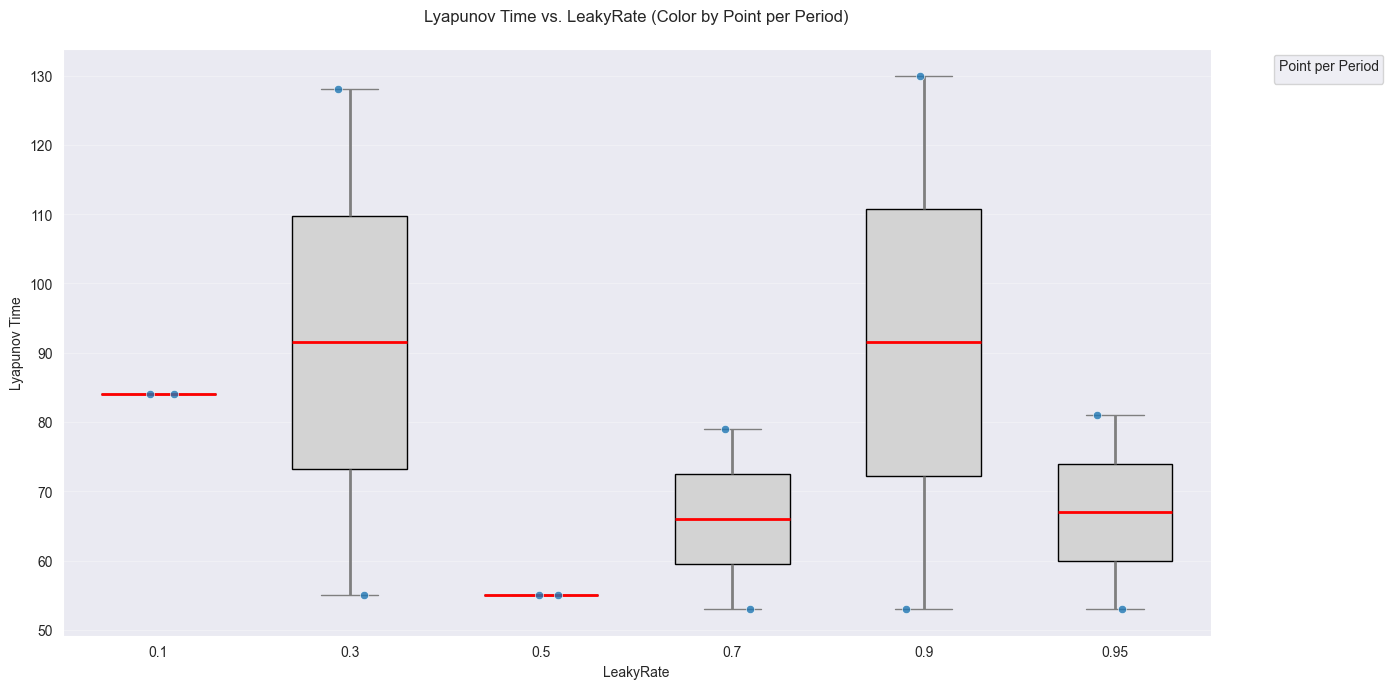

In [5]:
df1 = pd.DataFrame({
    'LyapunovTime': lyap_times,
    'LeakyRate': leaky_rates,
})

plt.figure(figsize=(14, 7))

# 1. Boxplot (grouped by LeakyRate)
sns.boxplot(
    data = df1,
    x = 'LeakyRate',
    y = 'LyapunovTime',
    color = 'lightgray',
    width = 0.6,
    showfliers = False,
    whiskerprops = {'linewidth': 2},
    boxprops = {'facecolor': 'lightgray', 'edgecolor': 'black'},
    medianprops = {'color': 'red', 'linewidth': 2}
)

# 2. Stripplot (color by File)
stripplot = sns.stripplot(
    data = df1,
    x = 'LeakyRate',
    y = 'LyapunovTime',
    #palette='tab20',     
    #palette="Set2",
    jitter = True,
    size = 6,
    alpha = 0.8,
    linewidth = 0.5,
    edgecolor = 'white',
    dodge = False         # Important for alignment with boxplot
)


plt.title('Lyapunov Time vs. LeakyRate (Color by Point per Period)', pad=20)
plt.xlabel('LeakyRate')
plt.ylabel('Lyapunov Time')
plt.grid(axis='y', alpha=0.3)

# Improve legend
handles, labels = stripplot.get_legend_handles_labels()
plt.legend(
    handles, 
    labels,
    title='Point per Period',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small'
)

# Rotate x-axis labels if many LeakyRate bins
if len(df1['LeakyRate'].unique()) > 10:
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
from natsort import natsorted

all_files = os.listdir(system_path)
files_to_plot = all_files[:]
sort = natsorted([name[:-4] for name in files_to_plot])

In [7]:
all_leaky = []
all_lyap = []
file_labels = []
all_Kldiv = []

for i, file in enumerate(sort):
    file_path = os.path.join(system_path, file + ".pkl")
    #print(file_path)
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    
    # Initialize arrays for this file
    leaky_rates = []
    lyap_times = []
    Kldivs = []
    
    for entry in data:
        try:
            leaky = entry['parameters']['LeakyRate']
            lyap_time = chaos_utils.comparative_lyapunov_time(
                        truth=entry['true_value'],
                        predictions=entry["predictions"]
            )
            Kldiv = chaos_utils.KLdivergence(
                        truth=entry['true_value'],
                        predictions=entry["predictions"])

            leaky_rates.append(leaky)
            lyap_times.append(lyap_time)
            Kldivs.append(Kldiv)

        except Exception as e:
            print(f"Error processing entry in {file}: {e}")
            continue

    all_leaky.extend(leaky_rates)
    all_lyap.extend(lyap_times)
    all_Kldiv.extend(Kldivs)
    file_labels.extend([file]*len(leaky_rates))

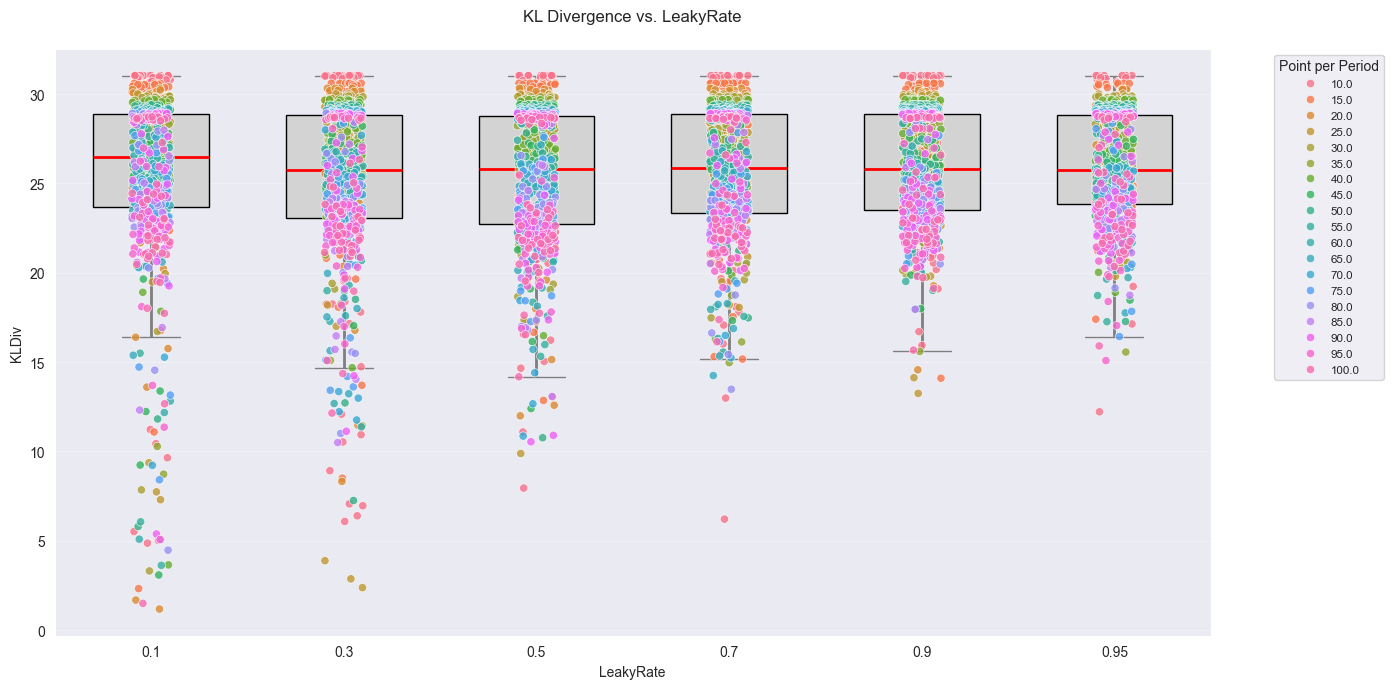

In [8]:
selection = 1
selected_lyap = all_lyap[::selection]
selected_leaky = all_leaky[::selection]
selected_file_labels = file_labels[::selection]
selected_divs = all_Kldiv[::selection]

# Create DataFrame with File information
df = pd.DataFrame({
    'LyapunovTime': selected_lyap,
    'LeakyRate': selected_leaky,
    'KLDivergence' : selected_divs,
    'File': selected_file_labels  # Add file/period information
})

plt.figure(figsize=(14, 7))

# 1. Boxplot (grouped by LeakyRate)
sns.boxplot(
    data=df,
    x='LeakyRate',
    y='KLDivergence',
    color='lightgray',
    width=0.6,
    showfliers=False,
    whiskerprops={'linewidth': 2},
    boxprops={'facecolor': 'lightgray', 'edgecolor': 'black'},
    medianprops={'color': 'red', 'linewidth': 2}
)

# 2. Stripplot (color by File)
stripplot = sns.stripplot(
    data=df,
    x='LeakyRate',
    y='KLDivergence',
    hue='File',           # Color points by File instead of LeakyRate
    #palette='tab20',     # Use qualitative palette for distinct files
    palette=sns.color_palette("husl", n_colors=len(df['File'].unique())),
    jitter=True,
    size=6,
    alpha=0.8,
    linewidth=0.5,
    edgecolor='white',
    dodge=False         # Important for alignment with boxplot
)


plt.title('KL Divergence vs. LeakyRate', pad=20)
plt.xlabel('LeakyRate')
plt.ylabel('KLDiv')
#plt.yscale('log')
plt.grid(axis='y', alpha=0.3)

# Improve legend
handles, labels = stripplot.get_legend_handles_labels()
plt.legend(
    handles, 
    labels,
    title='Point per Period',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small'
)

# Rotate x-axis labels if many LeakyRate bins
if len(df['LeakyRate'].unique()) > 10:
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Grid

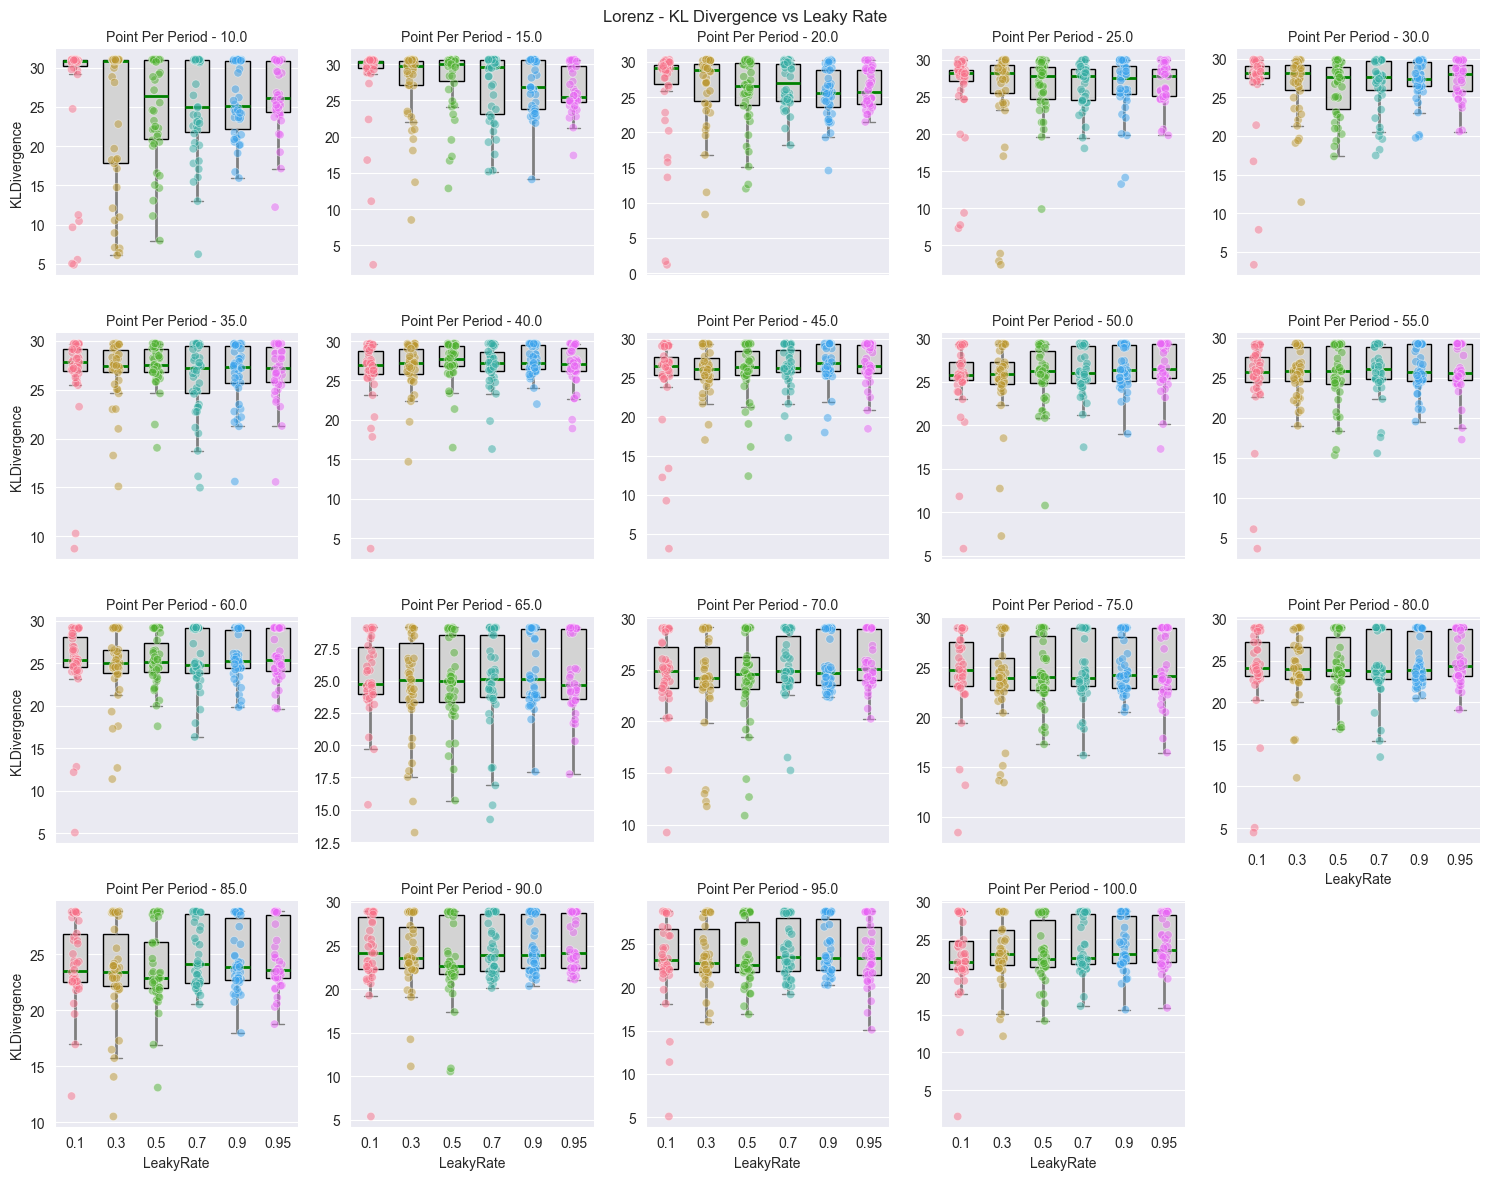

In [9]:
g = sns.FacetGrid(df, col='File', col_wrap=5, height=3, sharey=False)

g.map(sns.boxplot,
    'LeakyRate',
    'KLDivergence',
    color='lightgray',
    width=0.6,
    order = df["LeakyRate"].unique(),
    showfliers=False,
    whiskerprops={'linewidth': 2},
    boxprops={'facecolor': 'lightgray', 'edgecolor': 'black'},
    medianprops={'color': 'green', 'linewidth': 2})

g.map(sns.stripplot, 
    'LeakyRate', 
    'KLDivergence',    
    hue = df["LeakyRate"],
    palette=sns.color_palette("husl", n_colors=len(df['LeakyRate'].unique())),
    jitter=True,
    order = df["LeakyRate"].unique(),
    size=6,
    alpha=0.5,
    linewidth=0.5,
    edgecolor='white',
    dodge=False)

g.set_titles("Point Per Period - {col_name}")
g.fig.suptitle(f"{system_name} - KL Divergence vs Leaky Rate")
plt.tight_layout()
plt.savefig(f"{save_path}/{system_name}_KLDiv_LeakyRate", dpi = 600)